In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import vgg16, resnet50
from torchvision.datasets import VOCDetection
from torchvision.transforms.functional import to_tensor
from PIL import Image
from xml.etree.ElementTree import parse
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

In [2]:
# VOC2007 데이터셋을 로드하고 전처리하는 클래스
class PascalVOCDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_transform=None):
        self.data_dir = data_dir
        self.data = os.listdir(data_dir)
        self.imgs = list(filter(lambda x: x.endswith('.jpg'), self.data))
        self.annotations = list(filter(lambda x: x.endswith('.xml'), self.data))
        self.transform = transform
        self.target_transform = target_transform
        self.class_names = (
            'aeroplane', 'bicycle', 'bird', 'boat',
            'bottle', 'bus', 'car', 'cat', 'chair',
            'cow', 'diningtable', 'dog', 'horse',
            'motorbike', 'person', 'pottedplant',
            'sheep', 'sofa', 'train', 'tvmonitor'
        )
        self.class_labels = {name: i for i, name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        # 이미지와 레이블을 가져옵니다.
        target = parse(f'{self.data_dir}/{self.annotations[index]}').getroot()
        image = Image.open(f"{self.data_dir}/{self.imgs[index]}").convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        image = np.array(image)
#         label = self.class_labels[target.find('object').find('name').text]
        # 이미지를 PyTorch Tensor로 변환하고 레이블을 one-hot 벡터로 변환합니다.
        # image = to_tensor(image)
        labels = torch.zeros(len(self.class_names), dtype=torch.float32)  # VOC2007 데이터셋은 총 20개의 클래스를 가집니다.
        for obj in target.iter('object'):
            label = obj.find('name').text
            labels[self.class_labels[label]] = 1.0

        return image, labels
    
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

    
class ResNet50(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = resnet50(pretrained=True)
        
        input_features_fc_layer = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(input_features_fc_layer, 20, bias=False)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        
        return x

In [3]:
# GPU를 사용할 수 있다면 사용합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ResNet50().to(device)
model = resnet50(pretrained=True).to(device)

In [4]:
for param in model.parameters():
    param.requires_grad = False

In [5]:
model.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(2048, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, 20)).to(device)

In [6]:
summary(model, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 20]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]    

In [7]:
# 데이터 전처리를 정의합니다. 이미지를 VGG16 모델의 입력에 맞게 resize하고 normalize합니다.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
#     transforms.GaussianBlur(kernel_size=(19,19), sigma=(1.0, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
dataset = PascalVOCDataset('D:\dataset\synth_data', transform=transform)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.6)
validation_size = int(dataset_size * 0.2)
test_size = dataset_size - train_size - validation_size

In [9]:
print(f'Train size:{train_size}')
print(f'Validation size:{validation_size}')
print(f'Test size:{test_size}')

Train size:9397
Validation size:3132
Test size:3133


In [10]:
torch.manual_seed(7)
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


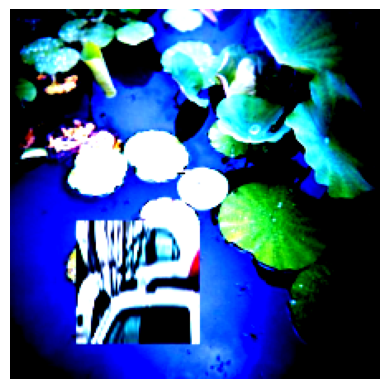

In [12]:
plt.axis('off')
plt.imshow(torch.Tensor(test_dataset[1][0]).permute(1, 2, 0))

In [13]:
# 손실 함수와 최적화 알고리즘을 정의합니다.
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# 모델을 학습합니다.
num_epochs = 100

train_losses, validation_losses = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        #labels = labels.long().to(device)
        labels = torch.argmax(labels,dim=1).to(device)

        optimizer.zero_grad()
        
        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        
        for images, labels in tqdm(validation_dataloader):
            images = images.to(device)
            #labels = labels.long().to(device)
            labels = torch.argmax(labels,dim=1).to(device)

            # 순전파
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        validation_loss = val_loss / len(validation_dataloader)
        validation_losses.append(validation_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss(train/val): {train_loss:.4f}/{validation_loss:.4f}")

print("Training complete.")

# 학습된 모델을 저장합니다.
torch.save(model, "resnet50_voc2007_synth.pth")

100%|██████████| 97/97 [01:37<00:00,  1.01s/it]


Epoch [1/100], Loss(train/val): 2.1446/1.6859


100%|██████████| 97/97 [00:39<00:00,  2.45it/s]


Epoch [2/100], Loss(train/val): 1.7829/1.5540


100%|██████████| 97/97 [00:36<00:00,  2.64it/s]


Epoch [3/100], Loss(train/val): 1.6708/1.4758


100%|██████████| 97/97 [00:35<00:00,  2.70it/s]


Epoch [4/100], Loss(train/val): 1.6069/1.4282


100%|██████████| 97/97 [00:39<00:00,  2.49it/s]


Epoch [5/100], Loss(train/val): 1.5547/1.4147


100%|██████████| 97/97 [00:38<00:00,  2.54it/s]


Epoch [6/100], Loss(train/val): 1.5307/1.3820


100%|██████████| 97/97 [00:35<00:00,  2.71it/s]


Epoch [7/100], Loss(train/val): 1.4903/1.3702


100%|██████████| 97/97 [00:38<00:00,  2.49it/s]


Epoch [8/100], Loss(train/val): 1.4792/1.3570


100%|██████████| 97/97 [00:37<00:00,  2.61it/s]


Epoch [9/100], Loss(train/val): 1.4672/1.3495


100%|██████████| 97/97 [00:38<00:00,  2.55it/s]


Epoch [10/100], Loss(train/val): 1.4320/1.2937


100%|██████████| 97/97 [00:37<00:00,  2.62it/s]


Epoch [11/100], Loss(train/val): 1.4262/1.3031


100%|██████████| 97/97 [00:37<00:00,  2.61it/s]


Epoch [12/100], Loss(train/val): 1.4277/1.3193


100%|██████████| 97/97 [00:37<00:00,  2.61it/s]


Epoch [13/100], Loss(train/val): 1.3833/1.3039


100%|██████████| 97/97 [00:36<00:00,  2.66it/s]


Epoch [14/100], Loss(train/val): 1.3964/1.3473


100%|██████████| 97/97 [00:36<00:00,  2.64it/s]


Epoch [15/100], Loss(train/val): 1.3868/1.2954


100%|██████████| 97/97 [00:37<00:00,  2.59it/s]


Epoch [16/100], Loss(train/val): 1.3683/1.3424


100%|██████████| 97/97 [00:36<00:00,  2.63it/s]


Epoch [17/100], Loss(train/val): 1.3637/1.2883


100%|██████████| 97/97 [00:38<00:00,  2.51it/s]


Epoch [18/100], Loss(train/val): 1.3610/1.2904


100%|██████████| 97/97 [00:39<00:00,  2.49it/s]


Epoch [19/100], Loss(train/val): 1.3397/1.2790


100%|██████████| 97/97 [00:40<00:00,  2.41it/s]


Epoch [20/100], Loss(train/val): 1.3461/1.3073


100%|██████████| 97/97 [00:36<00:00,  2.62it/s]


Epoch [21/100], Loss(train/val): 1.3117/1.2957


100%|██████████| 97/97 [00:39<00:00,  2.47it/s]


Epoch [22/100], Loss(train/val): 1.3146/1.3240


100%|██████████| 97/97 [00:37<00:00,  2.59it/s]


Epoch [23/100], Loss(train/val): 1.2945/1.2901


100%|██████████| 97/97 [00:36<00:00,  2.64it/s]


Epoch [24/100], Loss(train/val): 1.3038/1.3572


100%|██████████| 97/97 [00:37<00:00,  2.61it/s]


Epoch [25/100], Loss(train/val): 1.2882/1.3144


100%|██████████| 97/97 [00:36<00:00,  2.63it/s]


Epoch [26/100], Loss(train/val): 1.2839/1.3067


100%|██████████| 97/97 [00:36<00:00,  2.64it/s]


Epoch [27/100], Loss(train/val): 1.2736/1.3542


100%|██████████| 97/97 [00:37<00:00,  2.60it/s]


Epoch [28/100], Loss(train/val): 1.2676/1.2995


100%|██████████| 97/97 [00:37<00:00,  2.62it/s]


Epoch [29/100], Loss(train/val): 1.2580/1.2937


100%|██████████| 97/97 [00:36<00:00,  2.64it/s]


Epoch [30/100], Loss(train/val): 1.2641/1.3314


100%|██████████| 97/97 [00:35<00:00,  2.71it/s]


Epoch [31/100], Loss(train/val): 1.2577/1.3231


100%|██████████| 97/97 [00:36<00:00,  2.68it/s]


Epoch [32/100], Loss(train/val): 1.2522/1.3083


100%|██████████| 97/97 [00:36<00:00,  2.65it/s]


Epoch [33/100], Loss(train/val): 1.2324/1.3425


100%|██████████| 97/97 [00:36<00:00,  2.62it/s]


Epoch [34/100], Loss(train/val): 1.2320/1.3005


100%|██████████| 97/97 [00:35<00:00,  2.72it/s]


Epoch [35/100], Loss(train/val): 1.2129/1.3092


100%|██████████| 97/97 [00:36<00:00,  2.67it/s]


Epoch [36/100], Loss(train/val): 1.2216/1.3161


100%|██████████| 97/97 [00:36<00:00,  2.66it/s]


Epoch [37/100], Loss(train/val): 1.1964/1.3103


100%|██████████| 97/97 [00:36<00:00,  2.63it/s]


Epoch [38/100], Loss(train/val): 1.2073/1.3448


100%|██████████| 97/97 [00:35<00:00,  2.73it/s]


Epoch [39/100], Loss(train/val): 1.1897/1.3261


100%|██████████| 97/97 [00:36<00:00,  2.64it/s]


Epoch [40/100], Loss(train/val): 1.1801/1.3288


100%|██████████| 97/97 [00:36<00:00,  2.68it/s]


Epoch [41/100], Loss(train/val): 1.1849/1.3477


100%|██████████| 97/97 [00:36<00:00,  2.67it/s]


Epoch [42/100], Loss(train/val): 1.1769/1.3250


100%|██████████| 97/97 [00:35<00:00,  2.74it/s]


Epoch [43/100], Loss(train/val): 1.1659/1.3438


100%|██████████| 97/97 [00:36<00:00,  2.67it/s]


Epoch [44/100], Loss(train/val): 1.1488/1.3387


100%|██████████| 97/97 [00:36<00:00,  2.68it/s]


Epoch [45/100], Loss(train/val): 1.1736/1.3540


100%|██████████| 97/97 [00:36<00:00,  2.69it/s]


Epoch [46/100], Loss(train/val): 1.1458/1.3324


100%|██████████| 97/97 [00:35<00:00,  2.70it/s]


Epoch [47/100], Loss(train/val): 1.1539/1.3675


100%|██████████| 97/97 [00:36<00:00,  2.68it/s]


Epoch [48/100], Loss(train/val): 1.1334/1.3173


100%|██████████| 97/97 [00:37<00:00,  2.62it/s]


Epoch [49/100], Loss(train/val): 1.1467/1.3801


100%|██████████| 97/97 [00:36<00:00,  2.68it/s]


Epoch [50/100], Loss(train/val): 1.1373/1.3362


100%|██████████| 97/97 [00:35<00:00,  2.73it/s]


Epoch [51/100], Loss(train/val): 1.1411/1.3554


100%|██████████| 97/97 [00:36<00:00,  2.69it/s]


Epoch [52/100], Loss(train/val): 1.1182/1.3870


100%|██████████| 97/97 [00:36<00:00,  2.66it/s]


Epoch [53/100], Loss(train/val): 1.1254/1.3536


100%|██████████| 97/97 [00:36<00:00,  2.68it/s]


Epoch [54/100], Loss(train/val): 1.1036/1.3542


100%|██████████| 97/97 [00:36<00:00,  2.67it/s]


Epoch [55/100], Loss(train/val): 1.1192/1.3801


100%|██████████| 97/97 [00:36<00:00,  2.63it/s]


Epoch [56/100], Loss(train/val): 1.1228/1.3599


100%|██████████| 97/97 [00:36<00:00,  2.69it/s]


Epoch [57/100], Loss(train/val): 1.1084/1.3998


100%|██████████| 97/97 [00:36<00:00,  2.69it/s]


Epoch [58/100], Loss(train/val): 1.1009/1.4073


100%|██████████| 97/97 [00:35<00:00,  2.70it/s]


Epoch [59/100], Loss(train/val): 1.0803/1.3869


100%|██████████| 97/97 [00:36<00:00,  2.68it/s]


Epoch [60/100], Loss(train/val): 1.1173/1.4112


100%|██████████| 97/97 [00:36<00:00,  2.68it/s]


Epoch [61/100], Loss(train/val): 1.0781/1.3859


100%|██████████| 97/97 [00:37<00:00,  2.61it/s]


Epoch [62/100], Loss(train/val): 1.0658/1.3699


100%|██████████| 97/97 [00:36<00:00,  2.67it/s]


Epoch [63/100], Loss(train/val): 1.0788/1.4391


100%|██████████| 97/97 [00:38<00:00,  2.54it/s]


Epoch [64/100], Loss(train/val): 1.0661/1.3755


100%|██████████| 97/97 [00:37<00:00,  2.57it/s]


Epoch [65/100], Loss(train/val): 1.0900/1.4052


100%|██████████| 97/97 [00:37<00:00,  2.59it/s]


Epoch [66/100], Loss(train/val): 1.0674/1.4014


100%|██████████| 97/97 [00:38<00:00,  2.52it/s]


Epoch [67/100], Loss(train/val): 1.0402/1.4300


100%|██████████| 97/97 [00:38<00:00,  2.53it/s]


Epoch [68/100], Loss(train/val): 1.0662/1.4038


100%|██████████| 97/97 [00:38<00:00,  2.51it/s]


Epoch [69/100], Loss(train/val): 1.0531/1.4249


100%|██████████| 97/97 [00:37<00:00,  2.56it/s]


Epoch [70/100], Loss(train/val): 1.0519/1.4128


100%|██████████| 97/97 [00:38<00:00,  2.52it/s]


Epoch [71/100], Loss(train/val): 1.0390/1.3960


100%|██████████| 97/97 [00:38<00:00,  2.52it/s]


Epoch [72/100], Loss(train/val): 1.0382/1.4546


100%|██████████| 97/97 [00:37<00:00,  2.62it/s]


Epoch [73/100], Loss(train/val): 1.0462/1.4479


100%|██████████| 97/97 [00:36<00:00,  2.67it/s]


Epoch [74/100], Loss(train/val): 1.0615/1.4431


100%|██████████| 97/97 [00:36<00:00,  2.64it/s]


Epoch [75/100], Loss(train/val): 1.0227/1.4311


100%|██████████| 97/97 [00:37<00:00,  2.62it/s]


Epoch [76/100], Loss(train/val): 1.0237/1.4420


100%|██████████| 97/97 [00:36<00:00,  2.64it/s]


Epoch [77/100], Loss(train/val): 1.0139/1.4460


100%|██████████| 97/97 [00:35<00:00,  2.72it/s]


Epoch [78/100], Loss(train/val): 1.0388/1.4266


100%|██████████| 97/97 [00:36<00:00,  2.65it/s]


Epoch [79/100], Loss(train/val): 1.0081/1.4665


100%|██████████| 97/97 [00:36<00:00,  2.66it/s]


Epoch [80/100], Loss(train/val): 1.0134/1.4294


100%|██████████| 97/97 [00:36<00:00,  2.65it/s]


Epoch [81/100], Loss(train/val): 1.0318/1.4795


100%|██████████| 97/97 [00:36<00:00,  2.67it/s]


Epoch [82/100], Loss(train/val): 1.0055/1.4564


100%|██████████| 97/97 [00:36<00:00,  2.65it/s]


Epoch [83/100], Loss(train/val): 1.0053/1.4528


100%|██████████| 97/97 [00:36<00:00,  2.62it/s]


Epoch [84/100], Loss(train/val): 0.9875/1.4851


100%|██████████| 97/97 [00:37<00:00,  2.62it/s]


Epoch [85/100], Loss(train/val): 1.0159/1.4250


100%|██████████| 97/97 [00:36<00:00,  2.67it/s]


Epoch [86/100], Loss(train/val): 0.9971/1.4611


100%|██████████| 97/97 [00:40<00:00,  2.41it/s]


Epoch [87/100], Loss(train/val): 0.9983/1.4890


100%|██████████| 97/97 [00:39<00:00,  2.48it/s]


Epoch [88/100], Loss(train/val): 1.0079/1.5063


100%|██████████| 97/97 [00:39<00:00,  2.48it/s]


Epoch [89/100], Loss(train/val): 0.9858/1.4695


100%|██████████| 97/97 [00:38<00:00,  2.49it/s]


Epoch [90/100], Loss(train/val): 0.9809/1.4450


100%|██████████| 97/97 [01:37<00:00,  1.00s/it]


Epoch [91/100], Loss(train/val): 0.9745/1.5017


100%|██████████| 97/97 [00:39<00:00,  2.47it/s]


Epoch [92/100], Loss(train/val): 0.9806/1.5135


100%|██████████| 97/97 [00:37<00:00,  2.60it/s]


Epoch [93/100], Loss(train/val): 0.9769/1.4885


100%|██████████| 97/97 [00:36<00:00,  2.66it/s]


Epoch [94/100], Loss(train/val): 0.9595/1.5507


100%|██████████| 97/97 [00:36<00:00,  2.63it/s]


Epoch [95/100], Loss(train/val): 0.9732/1.4957


100%|██████████| 97/97 [00:36<00:00,  2.63it/s]


Epoch [96/100], Loss(train/val): 0.9624/1.5424


100%|██████████| 97/97 [00:36<00:00,  2.63it/s]


Epoch [97/100], Loss(train/val): 0.9975/1.5334


100%|██████████| 97/97 [00:36<00:00,  2.68it/s]


Epoch [98/100], Loss(train/val): 0.9874/1.5277


100%|██████████| 97/97 [00:37<00:00,  2.61it/s]


Epoch [99/100], Loss(train/val): 0.9669/1.5383


100%|██████████| 97/97 [00:36<00:00,  2.65it/s]

Epoch [100/100], Loss(train/val): 0.9779/1.5210
Training complete.


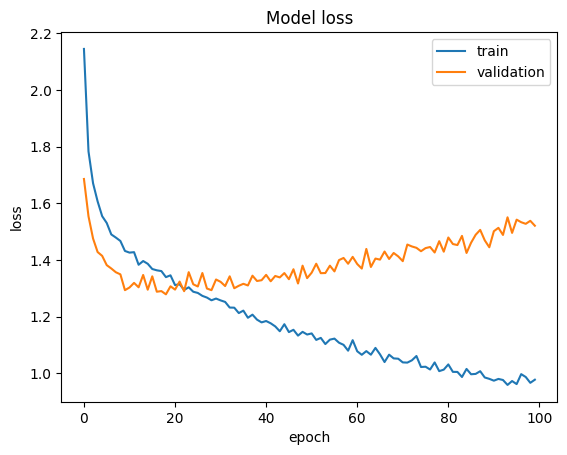

In [15]:
plt.plot(train_losses)
plt.plot(validation_losses)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [16]:
with torch.no_grad():
        model.eval()
        test_loss = 0.0
        accuracy_avg = 0.0
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            # 순전파
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            predicted_labels = np.multiply(outputs.cpu().numpy()>0, 1)
            true_labels = np.multiply(labels.cpu().numpy()>0, 1)

            accuracy_avg += accuracy_score(true_labels, predicted_labels)

        test_loss = running_loss / len(test_dataloader)
        accuracy_avg /= len(test_dataloader)

        print(f"Accuracy: {accuracy_avg:.4f}")
        print(f"Loss: {test_loss:.4f}")

  0%|          | 0/97 [00:01<?, ?it/s]


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target' in call to _thnn_nll_loss_forward

In [132]:
predicted_labels = np.multiply(outputs.cpu().numpy()>0, 1)
true_labels = np.multiply(labels.cpu().numpy()>0, 1)

In [139]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='micro')
recall = recall_score(true_labels, predicted_labels, average='micro')
f1 = f1_score(true_labels, predicted_labels, average='micro')

In [146]:
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'precision: {precision}')
print(f'F1 score: {f1}')

Accuracy: 0.25
Recall: 0.34
precision: 0.38636363636363635
F1 score: 0.36170212765957455


In [141]:
# Calculate Hamming loss
hamming = hamming_loss(true_labels, predicted_labels)

In [142]:
print(hamming)

0.09375


In [144]:
len(test_dataloader)

62